In [58]:
#Written by Sungwook Hong
#MSFE2017. Univ. of Illinois 

#Moving average stratey here uses two separate moving averages of the past 5 days and 20 days.
#When 5 days MA goes up across the 20 days' MA, we regard this as a signal for a buy 
#and it is cleared when it crosses back down. 
#it is also the same for the opposite case in which the 5 days MA goes below the 20 days MA. 
#it is short and be cleared when it crosses back up the 20 days MA. 

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import quandl
quandl.ApiConfig.api_key = "KuL7iL8zUg7h8iZzXh9_"

#def gen_stock_info(ticker, start, end):
def gen_stock_info():
    #stock_df = quandl.get(''.join(['WIKI/', ticker]), start_date=start, end_date=end)
    stock_df=quandl.get("BCHARTS/BITSTAMPUSD")
    stock_df = stock_df[(stock_df['Open'] != 0) & (stock_df['Close'] != 0)]
    return stock_df  #only need some columns


def add_Moving_Ave(stock_df):
    ma_list = ['ma5','ma20', 'ma60', 'ma120']
    window_list = [5, 20, 60, 120]
    for ma, window_ in zip(ma_list, window_list):
        stock_df[ma] = stock_df['Close'].rolling(window=window_).mean()
    return stock_df
    
    
def add_STD(stock_df):
    std_list = ['std_20']
    window_list = [20]
    for std, window_ in zip(std_list, window_list):
        stock_df[std] = stock_df['Close'].rolling(window=window_).std()
    return stock_df


def draw_stock(stock_df, window_=365):

    plt.figure(figsize=(20,10))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma5[-window_:],label='ma5')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    #plt.plot(stock_df.index[-window_:],stock_df.ma60[-window_:],label='ma60')
    #plt.plot(stock_df.index[-window_:],stock_df.ma120[-window_:],label='ma120')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#functions for analysis of an algorithm after simulations    
#############################   
def gen_drawdown_record(list_, K): # including up to K-th largest one
    
    record_ =[] 
    for i in range(1, len(list_)-1):
        if list_[i] > list_[i+1] and list_[i] > list_[i-1]: #find some number that are greater than the numbers next to it
            
            max_ = 0
            num_of_found = 0
            j = i+1
            while (num_of_found == 0) & (j < len(list_)):  #I can only look at the values from current point to the end
                if list_[i] <= list_[j]: #This is when I find the value recovered
                    num_of_found += 1
                    if num_of_found == 1: # just make sure if the value is the first recovery found
                        min_ = np.min(list_[i+1:j]) #Then between the start and the recovery, there should be a minimum 
                        k_index = stock_df.index.tolist().index(np.argmin(list_[i+1:j]))      
                        record_.append(((list_[i]-min_)/list_[i], i, k_index))  
                j = j+1
                if j == len(list_):
                    min_ = min(list_[i:])
                    min_index = stock_df.index.tolist().index(np.argmin(list_[i:]))
                    if (list_[i]-min_)/list_[i] > max_:
                        max_ = (list_[i]-min_)/list_[i]
                        record_.append((max_, i, min_index))
    if K > len(record_):
        return "K is greater than the number of drawdowns"
    else:        
        return sorted(record_, key= lambda pair:pair[0], reverse = True)[:K]
    
    
def draw_result_of_sim(stock_df, record_):
    plt.figure(figsize=(10,6))
    plt.plot(stock_df['Close'], label='Close')
    plt.plot(stock_df['Total_asset'],label='Total_asset')
    plt.plot(stock_df['Net_profit'],label='Net_profit')
    plt.plot(stock_df.index[record_[1]], stock_df['Total_asset'][record_[1]], 'o', color='black')
    plt.plot(stock_df.index[record_[2]], stock_df['Total_asset'][record_[2]], 'o', color='black')
    plt.title('Moving Average strategy with loss-cut')
    plt.xlabel('Time')
    plt.ylabel('In Dollars')
    plt.legend(loc='best')
    plt.show()
    
def draw_return_dist(stock_df):
    dailyreturn = np.log(stock_df.Close)-np.log(stock_df.Close.shift(1))
    day_ret = np.array(dailyreturn[1:])
    import seaborn as sns
    from scipy import stats
    sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm)    

def calc_quality_of_port(stock_df):
    return (stock_df.Cum_profit).mean()/(stock_df.Cum_profit).std()

def calc_max_drawdown(stock_df):
    max_drawdown, start_point, end_point = gen_drawdown_record(stock_df.Total_asset, 1)[0]
    return -round(max_drawdown*100), start_point, end_point

def get_final_total_value(stock_df):
    return stock_df.Cum_profit[-1]

In [59]:
#generate the stock info
stock_df = gen_stock_info()
stock_df = add_Moving_Ave(stock_df)
stock_df = add_STD(stock_df)
stock_df = stock_df.iloc[:,[0, 1, 2, 3, 7, 8, 11]]
stock_df = stock_df.iloc[19:,:]
ref_stock_df = stock_df.copy()

stock_df

,Open,High,Low,Close,ma5,ma20,std_20
Date,,,,,,,
2011-10-05,4.92,6.25,4.80,4.92,4.882,5.2395,0.444563
2011-10-06,4.88,4.99,4.80,4.80,4.878,5.1810,0.419660
2011-10-07,4.80,4.81,4.59,4.61,4.836,5.1350,0.429694
2011-10-08,4.57,4.57,3.99,3.99,4.660,5.0780,0.500217
2011-10-09,3.89,3.89,3.89,3.89,4.442,5.0300,0.565099
2011-10-10,3.99,4.51,3.99,4.51,4.360,5.0120,0.576090
2011-10-11,3.98,4.10,3.98,4.10,4.220,4.9710,0.611098
2011-10-12,3.95,3.99,3.93,3.93,4.084,4.9225,0.654015
2011-10-13,3.93,3.97,3.93,3.97,4.080,4.8380,0.662830


In [60]:
def simulate_algo(ref_stock_df, init_cash = 1000, target_port_ratio=0.5, loss_cut_ratio=0.95):
    # init_cash = 1000 
    # target_port_ratio = 0.5
    stock_df = ref_stock_df.copy()
    
    # initialization
    stock_df.loc[:,'Cash']=0  
    stock_df.at[stock_df.index[0],'Cash']=init_cash
    stock_df.loc[:,'Inventory']=0
    stock_df.loc[:,'Port_val']=0
    stock_df.loc[:,'Total_asset']=0
    stock_df.at[stock_df.index[0],'Total_asset'] = stock_df.iloc[0]['Cash']+stock_df.iloc[0]['Port_val']
    stock_df.loc[:,'Net_profit']=0
    stock_df.loc[:,'Signal'] = stock_df['ma5'] > stock_df['ma20']
    stock_df.loc[:,'Signal_change'] = abs(stock_df['Signal'].shift(1) - stock_df['Signal'])
    stock_df.at[stock_df.index[0],'Signal_change'] = 0
    
    
    #functions for orders in the simulation    
    ############################# 
    def short(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_t, Inventory_t = list_
        
        Inventory_t = Inventory_t - quantity 
        Cash_t = Cash_t + quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def long(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t + quantity 
        Cash_t = Cash_t - quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def clear_position(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_t, Inventory_t = list_
        Port_val_t = 0 
        Total_asset_t = 0 
        Net_profit_t = 0

        if Inventory_y < 0: #clear some short positions
            Inventory_t = Inventory_y + quantity 
            Cash_t = Cash_y - quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        elif Inventory_y > 0: #clear some long positions
            Inventory_t = Inventory_y - quantity 
            Cash_t = Cash_y + quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t  

    for i in range(1,len(stock_df)): 
        #targeted_quantity = total assset * target_ratio / unit price
        known_yesterday = stock_df.iloc[i-1,:] # all info
        known_today = stock_df.iloc[i,0] #only open price at the start of the market
        unknown_today = stock_df.iloc[i,1:4]
        open_y, high_y, low_y, close_y, ma5_y, ma20_y, std20_y, Cash_y, Inventory_y, Port_val_y, Total_asset_y, Net_profit_y, Signal_y, Signal_change_y = known_yesterday
        open_t = known_today
        high_t, low_t, close_t = unknown_today
        ref_list = (open_t, high_t, low_t, close_t, Cash_y, Inventory_y)
        
        targeted_quantity = Total_asset_y * target_port_ratio/open_t

        #if no signal change and the signal is false -> still ma5 < ma20
        if (Signal_change_y == 0) & (Signal_y == False):

            if targeted_quantity >= abs(Inventory_y):
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = short(targeted_quantity - abs(Inventory_y), ref_list)
            elif targeted_quantity < abs(Inventory_y):
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y)-targeted_quantity, ref_list)

        #if no signal change and the signal is True -> still ma5 > ma20
        elif (Signal_change_y == 0) & (Signal_y == True):  

            if targeted_quantity >= abs(Inventory_y):
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = long(targeted_quantity - abs(Inventory_y), ref_list)
            elif targeted_quantity < abs(Inventory_y):
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(Inventory_y-targeted_quantity, ref_list)

        #if there is signal change and the changed signal is True -> now ma5 > ma20        
        elif (Signal_change_y == 1) & (Signal_y == True):

            stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y), ref_list)
            ref_list_1 = open_t, high_t, low_t, close_t, stock_df.iloc[i,7], stock_df.iloc[i,8]
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = long(targeted_quantity - abs(ref_list_1[-1]), ref_list_1)

        #if there is signal change and the changed signal is False -> now ma5 < ma20     
        elif (Signal_change_y == 1) & (Signal_y == False):

            stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y), ref_list)
            ref_list_1 = open_t, high_t, low_t, close_t, stock_df.iloc[i,7], stock_df.iloc[i,8]
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = short(targeted_quantity - abs(ref_list_1[-1]), ref_list_1)

            
        Cash_t, Inventory_t = stock_df.iloc[i,7], stock_df.iloc[i,8]
        if (Inventory_t > 0) & ((Cash_t + low_t*Inventory_t) <= loss_cut_ratio*Total_asset_y):  
            traded_price = (loss_cut_ratio*Total_asset_y-Cash_t)/abs(Inventory_t)
            Cash_t = Cash_t + traded_price*abs(Inventory_t)
            Inventory_t = 0
            Port_val_t = 0 
            Total_asset_t = Cash_t + Port_val_t
            Net_profit_t = Total_asset_t - Total_asset_y
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t      


        elif (Inventory_t < 0) & ((Cash_t + high_t*Inventory_t) <= loss_cut_ratio*Total_asset_y):   # if happens right after we sell
            traded_price = (loss_cut_ratio*Total_asset_y-Cash_t)/Inventory_t
            Cash_t = Cash_t + traded_price*Inventory_t
            Inventory_t = 0
            Port_val_t = 0 
            Total_asset_t = Cash_t + Port_val_t
            Net_profit_t = Total_asset_t - Total_asset_y
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t
            
    stock_df['Cum_profit']=stock_df['Net_profit'].cumsum()
    return stock_df


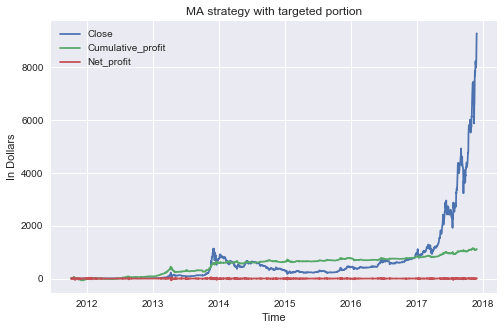

     Targeted portion = 0.1
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 1116.66
     The Quality of the Portfolio is 1.65
     Max Drawdown is -15.05 %


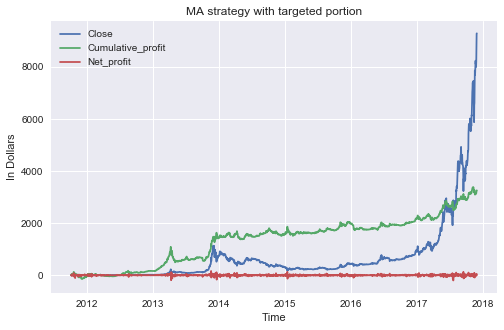

     Targeted portion = 0.2
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 3253.34
     The Quality of the Portfolio is 1.54
     Max Drawdown is -28.41 %


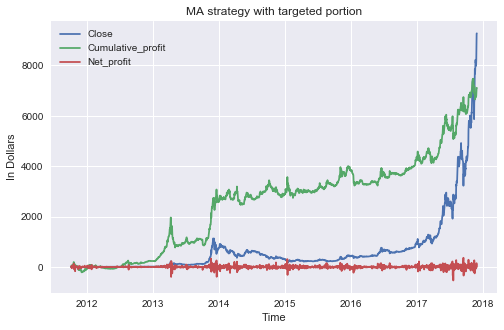

     Targeted portion = 0.3
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 7112.45
     The Quality of the Portfolio is 1.42
     Max Drawdown is -40.19 %


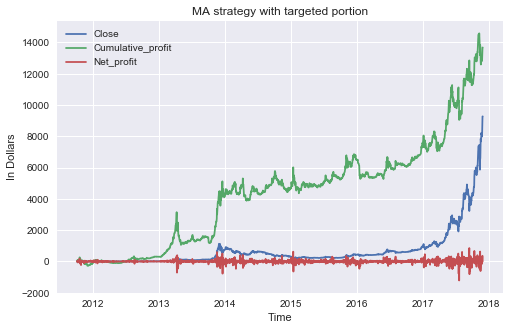

     Targeted portion = 0.4
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 13680.93
     The Quality of the Portfolio is 1.32
     Max Drawdown is -18.17 %


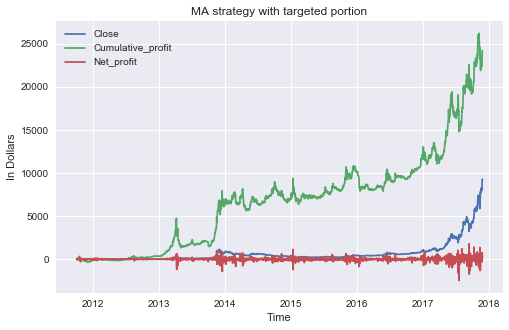

     Targeted portion = 0.5
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 24193.43
     The Quality of the Portfolio is 1.22
     Max Drawdown is -22.53 %


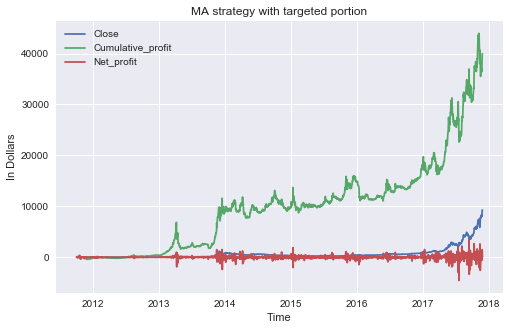

     Targeted portion = 0.6
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 39965.07
     The Quality of the Portfolio is 1.13
     Max Drawdown is -26.79 %


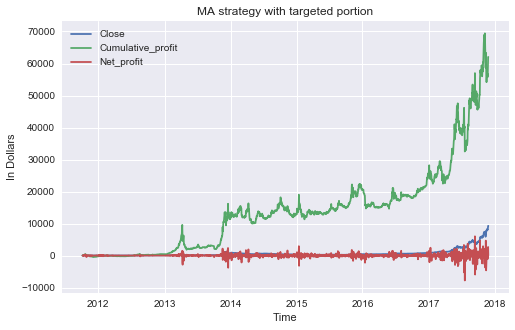

     Targeted portion = 0.7
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 62050.23
     The Quality of the Portfolio is 1.05
     Max Drawdown is -30.97 %


In [27]:
test_portion_list = np.arange(0.1, 0.8, 0.1) 
result_list = []
for portion in test_portion_list:
    temp_result_df = simulate_algo(stock_df, init_cash=1000, target_port_ratio=portion)
    result_list.append([get_final_total_value(temp_result_df), calc_quality_of_port(temp_result_df), calc_max_drawdown(temp_result_df)]) 
    draw_result_of_sim(temp_result_df)
    print('     Targeted portion =', portion)
    print('     Initial Investment Value $ 1000.00')
    print('     Final Portfolio Value: $', round(result_list[-1][0],2))
    print('     The Quality of the Portfolio is', round(result_list[-1][1],2))
    print('     Max Drawdown is', round(result_list[-1][2], 2), '%')
    

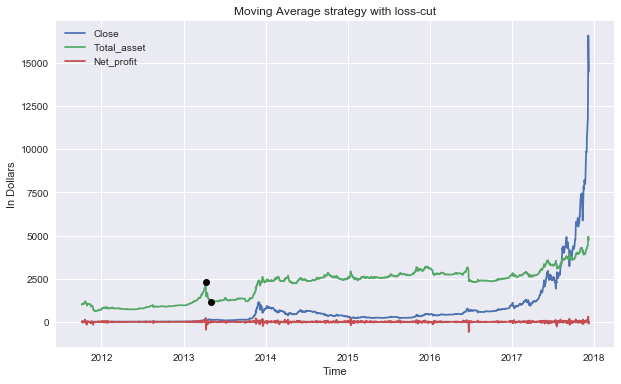

           Targeted portion = 0.3 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 3748.59
           The Quality of the Portfolio is 1.29
           Max Drawdown is -51.0 %


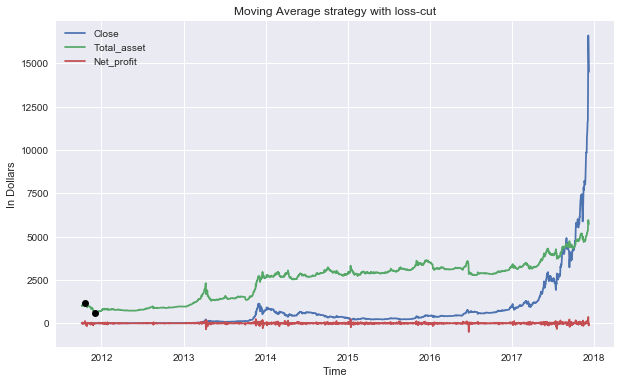

           Targeted portion = 0.3 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 4726.25
           The Quality of the Portfolio is 1.32
           Max Drawdown is -48.0 %


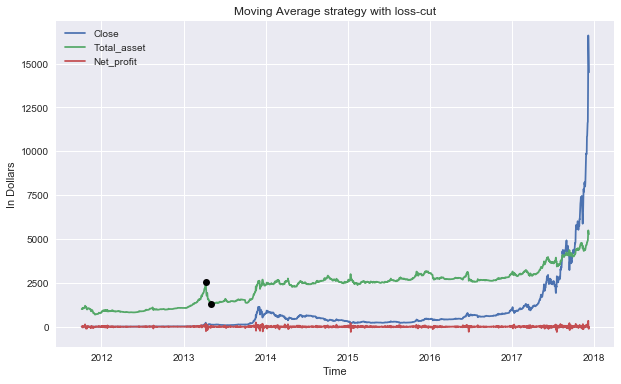

           Targeted portion = 0.3 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 4277.21
           The Quality of the Portfolio is 1.37
           Max Drawdown is -49.0 %


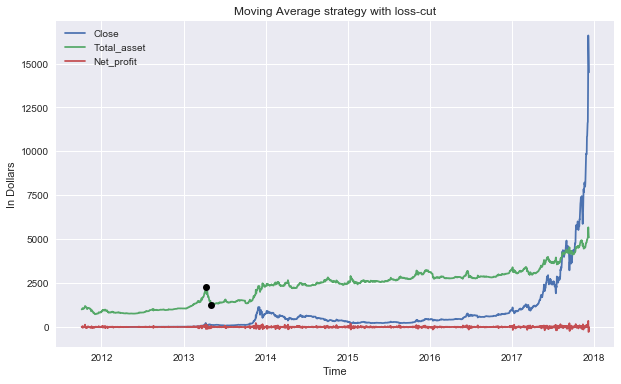

           Targeted portion = 0.3 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 4109.59
           The Quality of the Portfolio is 1.33
           Max Drawdown is -44.0 %


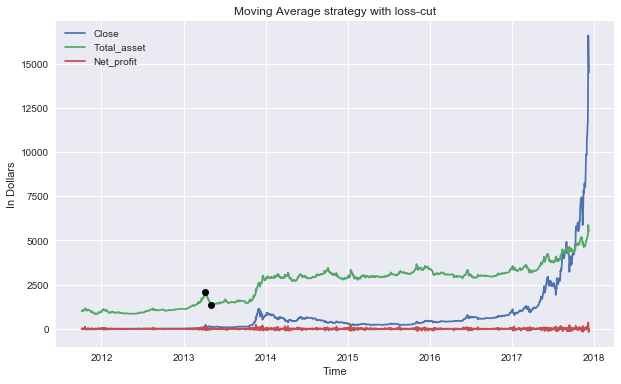

           Targeted portion = 0.3 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 4523.56
           The Quality of the Portfolio is 1.45
           Max Drawdown is -35.0 %


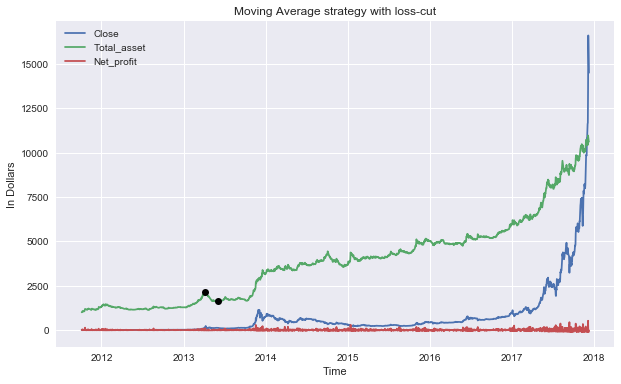

           Targeted portion = 0.3 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 9617.27
           The Quality of the Portfolio is 1.26
           Max Drawdown is -24.0 %


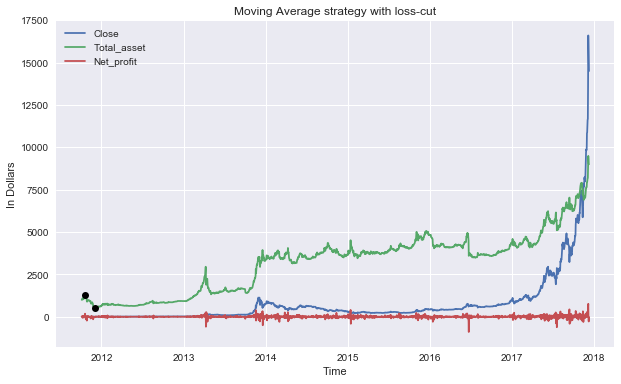

           Targeted portion = 0.4 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 8001.01
           The Quality of the Portfolio is 1.27
           Max Drawdown is -59.0 %


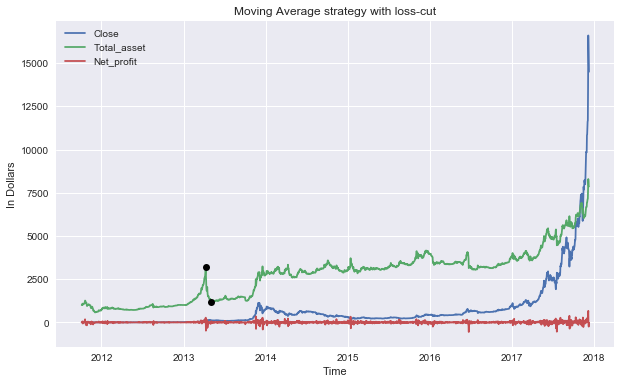

           Targeted portion = 0.4 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6865.55
           The Quality of the Portfolio is 1.24
           Max Drawdown is -63.0 %


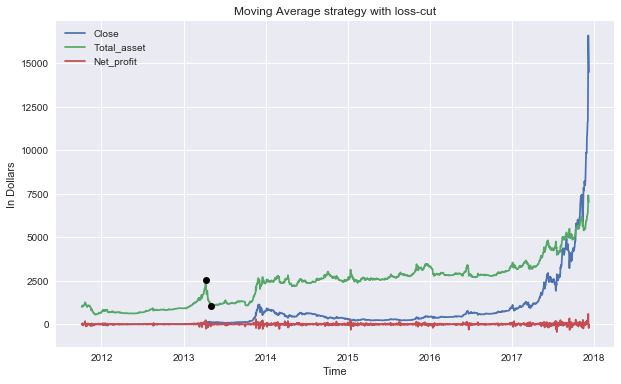

           Targeted portion = 0.4 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6032.32
           The Quality of the Portfolio is 1.12
           Max Drawdown is -59.0 %


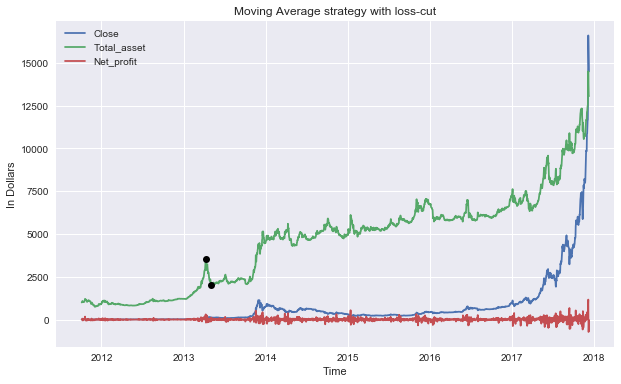

           Targeted portion = 0.4 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 12056.06
           The Quality of the Portfolio is 1.36
           Max Drawdown is -44.0 %


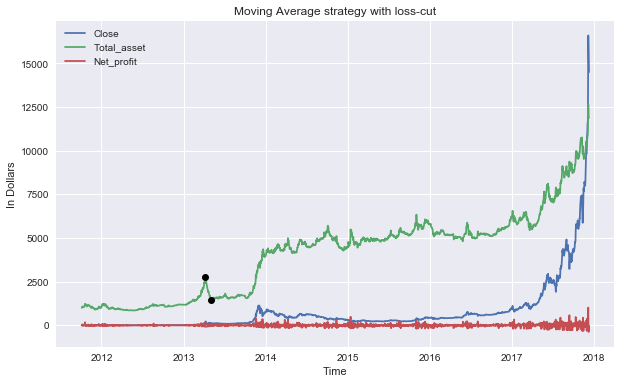

           Targeted portion = 0.4 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 10872.69
           The Quality of the Portfolio is 1.33
           Max Drawdown is -46.0 %


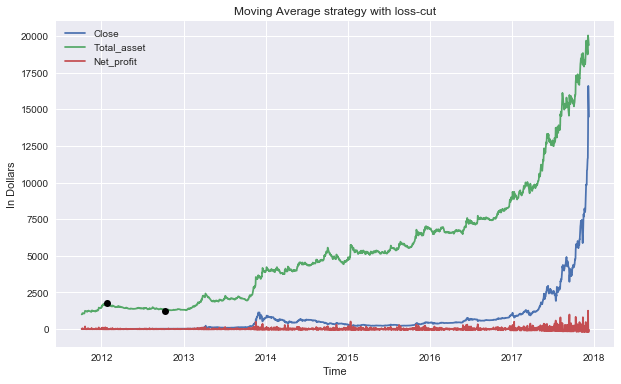

           Targeted portion = 0.4 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 18398.05
           The Quality of the Portfolio is 1.1
           Max Drawdown is -29.0 %


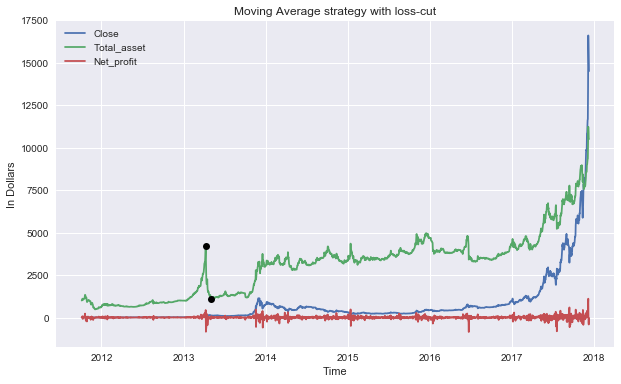

           Targeted portion = 0.5 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 9503.56
           The Quality of the Portfolio is 1.16
           Max Drawdown is -74.0 %


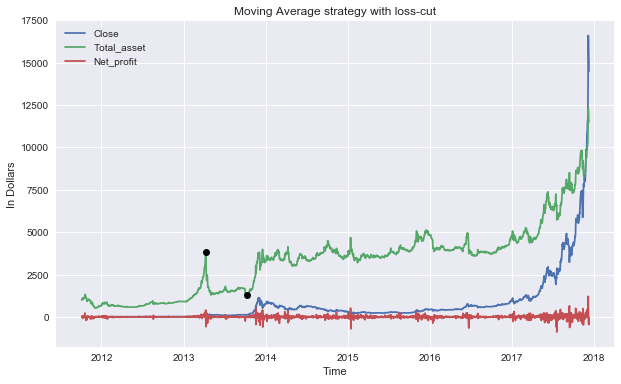

           Targeted portion = 0.5 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 10509.8
           The Quality of the Portfolio is 1.16
           Max Drawdown is -67.0 %


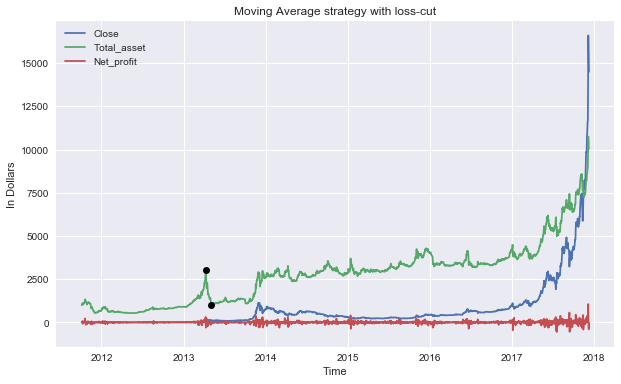

           Targeted portion = 0.5 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 9058.1
           The Quality of the Portfolio is 1.06
           Max Drawdown is -66.0 %


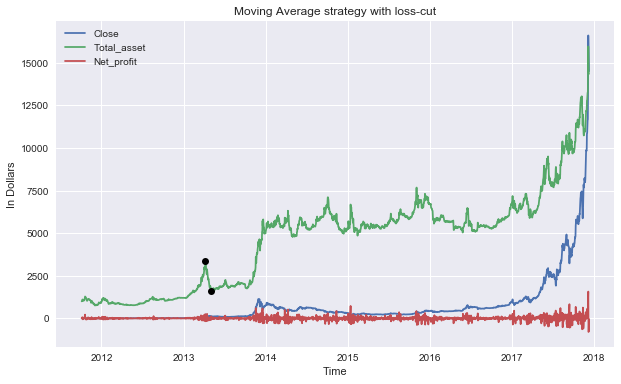

           Targeted portion = 0.5 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 13349.79
           The Quality of the Portfolio is 1.34
           Max Drawdown is -52.0 %


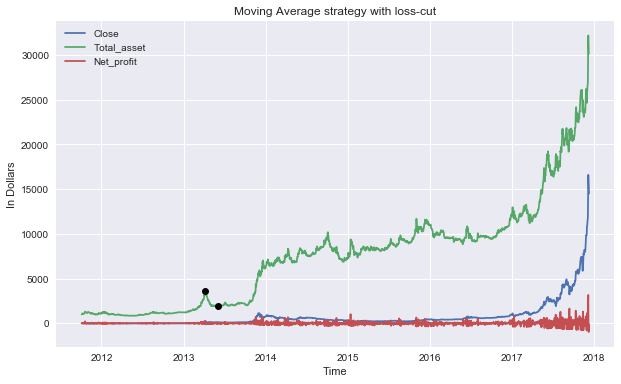

           Targeted portion = 0.5 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 29181.11
           The Quality of the Portfolio is 1.16
           Max Drawdown is -48.0 %


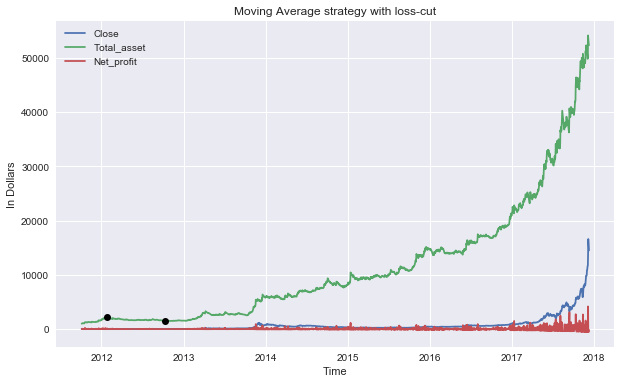

           Targeted portion = 0.5 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 51361.17
           The Quality of the Portfolio is 0.93
           Max Drawdown is -32.0 %


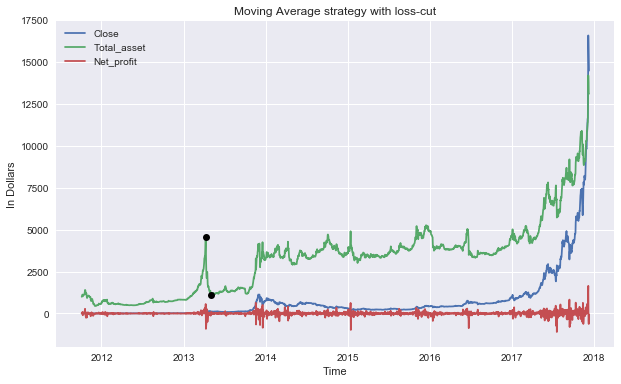

           Targeted portion = 0.6 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 12121.21
           The Quality of the Portfolio is 1.07
           Max Drawdown is -76.0 %


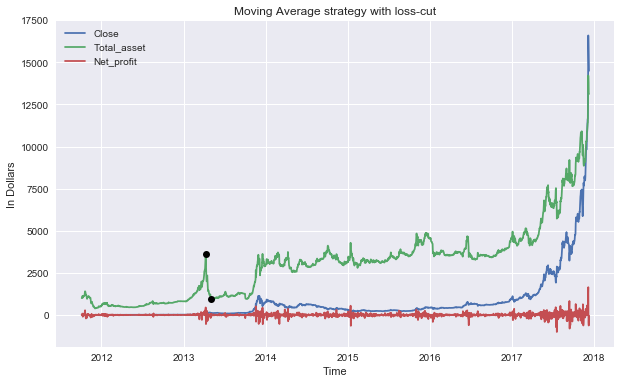

           Targeted portion = 0.6 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 12125.94
           The Quality of the Portfolio is 0.98
           Max Drawdown is -74.0 %


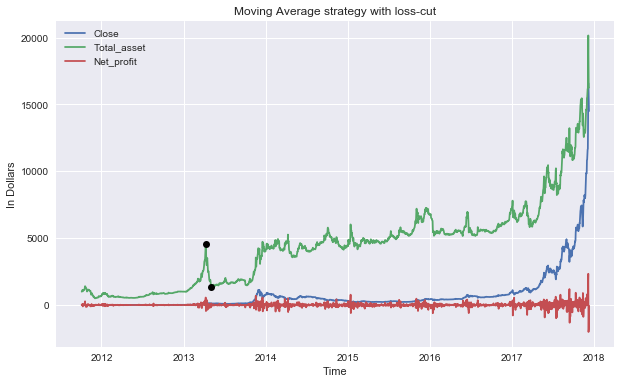

           Targeted portion = 0.6 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 15258.88
           The Quality of the Portfolio is 1.12
           Max Drawdown is -70.0 %


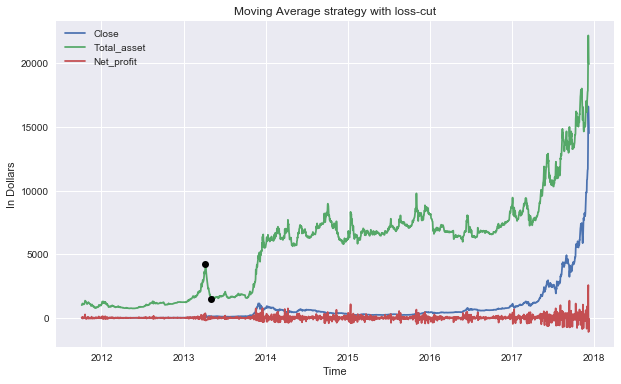

           Targeted portion = 0.6 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 18933.14
           The Quality of the Portfolio is 1.25
           Max Drawdown is -65.0 %


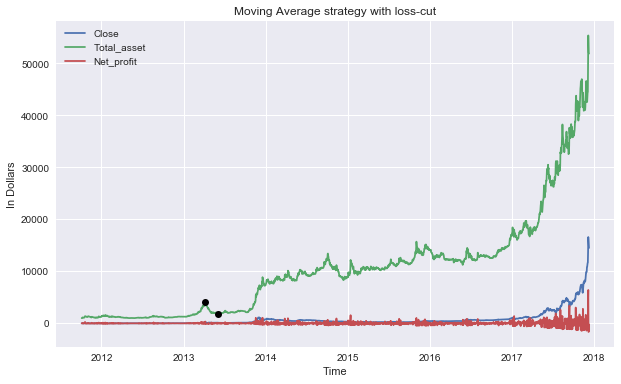

           Targeted portion = 0.6 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 50895.07
           The Quality of the Portfolio is 0.99
           Max Drawdown is -54.0 %


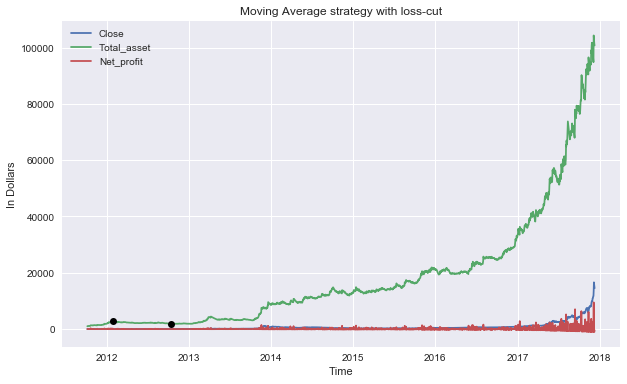

           Targeted portion = 0.6 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 99771.73
           The Quality of the Portfolio is 0.84
           Max Drawdown is -32.0 %


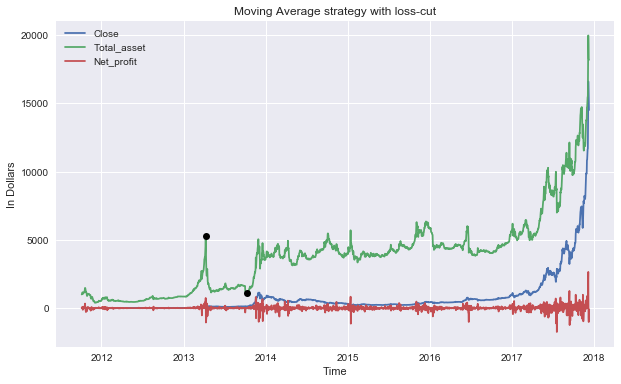

           Targeted portion = 0.7 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 17176.65
           The Quality of the Portfolio is 1.01
           Max Drawdown is -79.0 %


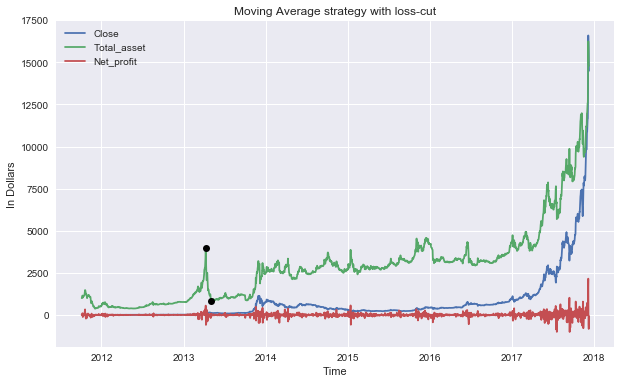

           Targeted portion = 0.7 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 13797.27
           The Quality of the Portfolio is 0.85
           Max Drawdown is -79.0 %


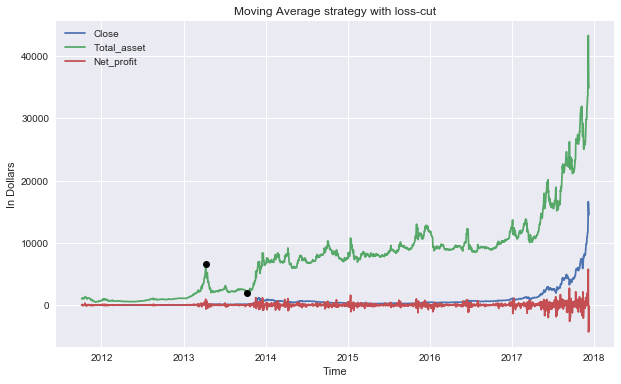

           Targeted portion = 0.7 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 33904.12
           The Quality of the Portfolio is 1.08
           Max Drawdown is -71.0 %


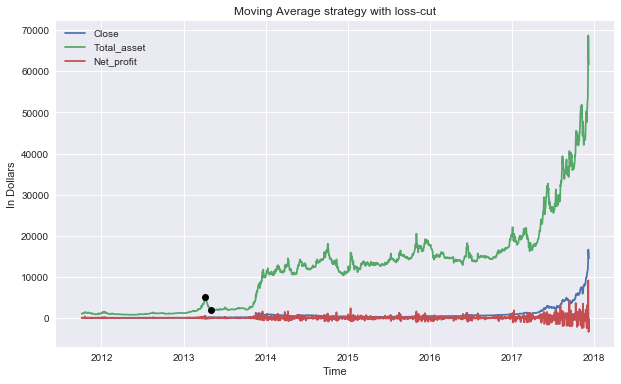

           Targeted portion = 0.7 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 60739.46
           The Quality of the Portfolio is 1.07
           Max Drawdown is -65.0 %


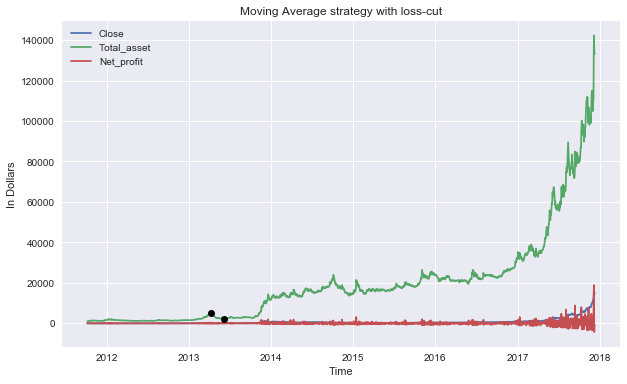

           Targeted portion = 0.7 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 132206.63
           The Quality of the Portfolio is 0.84
           Max Drawdown is -53.0 %


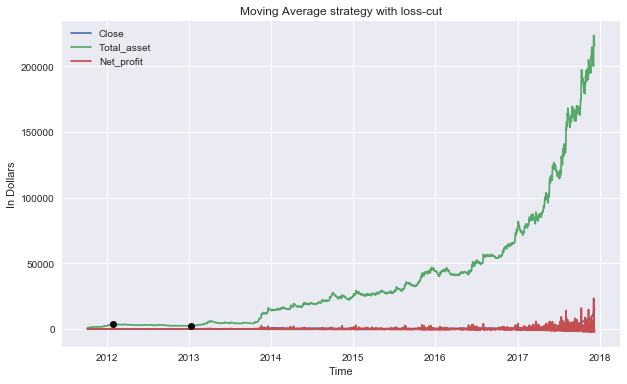

           Targeted portion = 0.7 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 214947.18
           The Quality of the Portfolio is 0.81
           Max Drawdown is -36.0 %


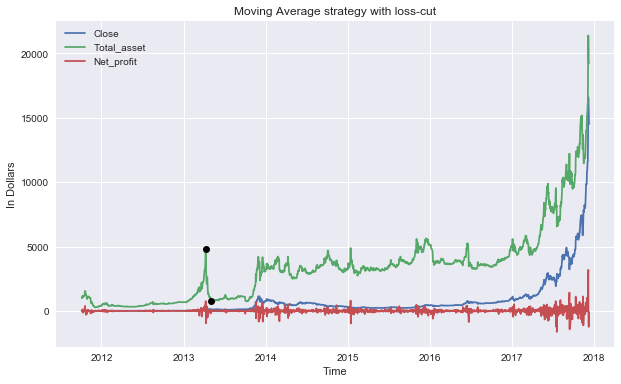

           Targeted portion = 0.8 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 18214.22
           The Quality of the Portfolio is 0.85
           Max Drawdown is -85.0 %


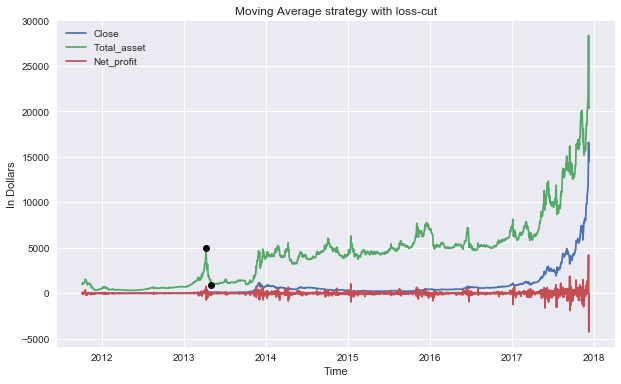

           Targeted portion = 0.8 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 19371.01
           The Quality of the Portfolio is 0.92
           Max Drawdown is -81.0 %


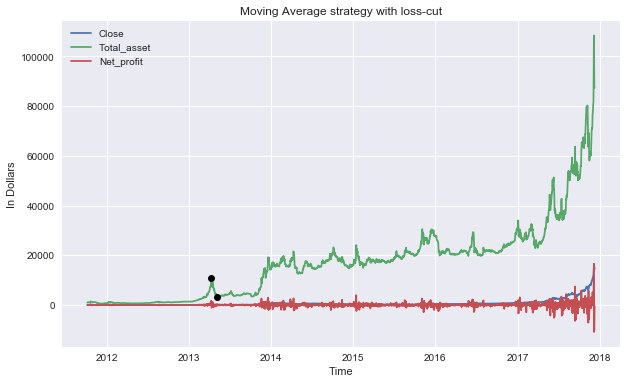

           Targeted portion = 0.8 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 86359.58
           The Quality of the Portfolio is 1.07
           Max Drawdown is -70.0 %


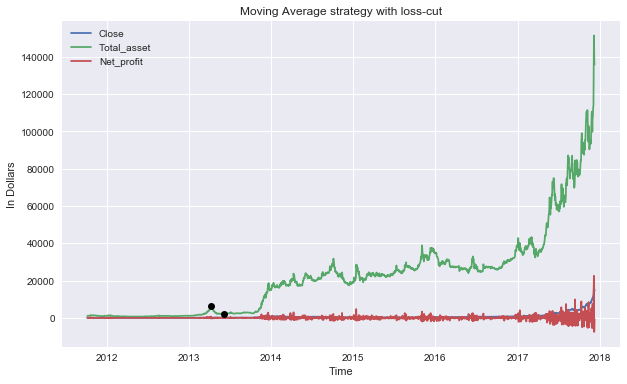

           Targeted portion = 0.8 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 134995.7
           The Quality of the Portfolio is 0.96
           Max Drawdown is -67.0 %


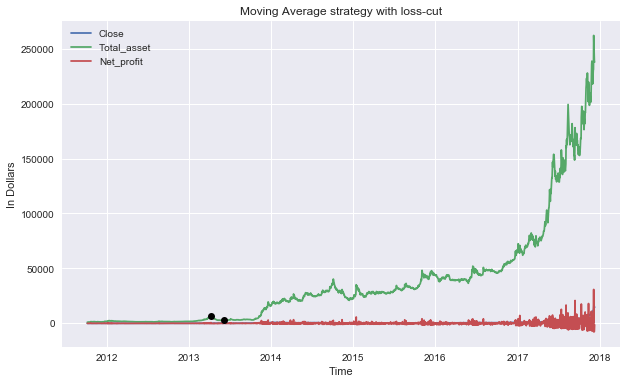

           Targeted portion = 0.8 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 236858.39
           The Quality of the Portfolio is 0.78
           Max Drawdown is -58.0 %


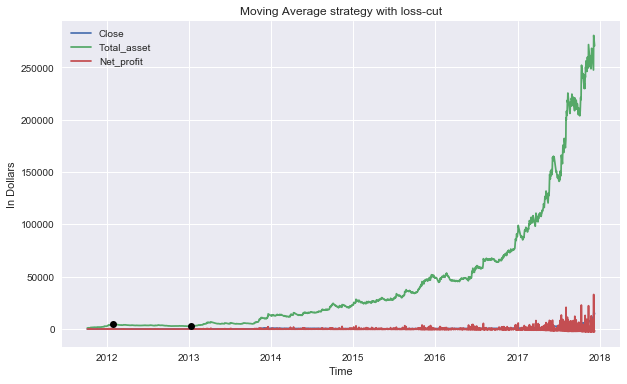

           Targeted portion = 0.8 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 269689.61
           The Quality of the Portfolio is 0.73
           Max Drawdown is -44.0 %


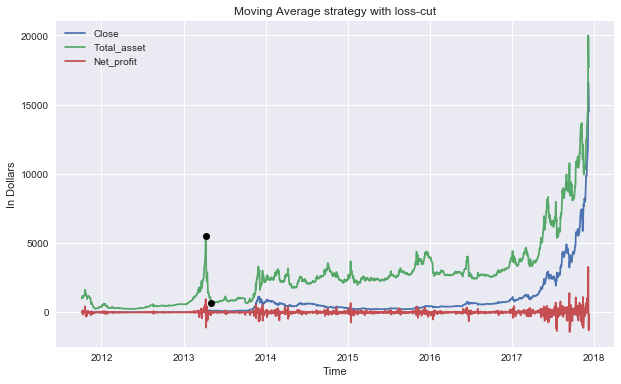

           Targeted portion = 0.9 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 16714.47
           The Quality of the Portfolio is 0.69
           Max Drawdown is -88.0 %


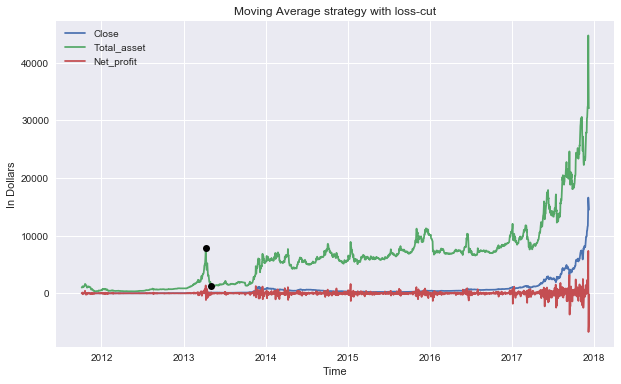

           Targeted portion = 0.9 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 31117.3
           The Quality of the Portfolio is 0.94
           Max Drawdown is -85.0 %


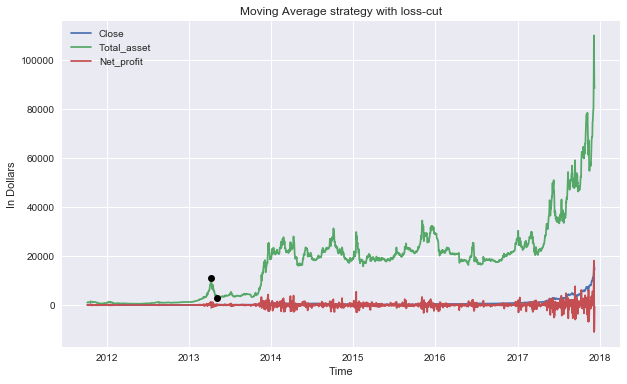

           Targeted portion = 0.9 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 87559.78
           The Quality of the Portfolio is 1.12
           Max Drawdown is -73.0 %


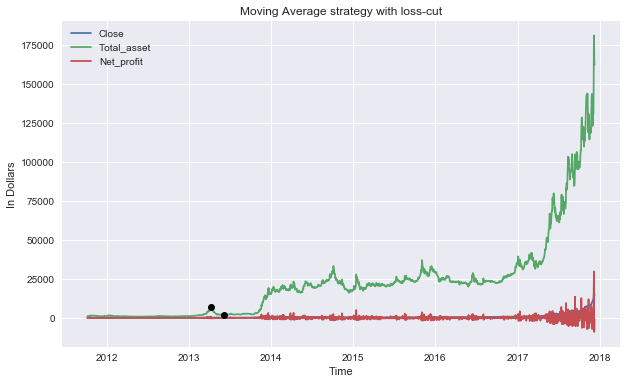

           Targeted portion = 0.9 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 161293.62
           The Quality of the Portfolio is 0.82
           Max Drawdown is -72.0 %


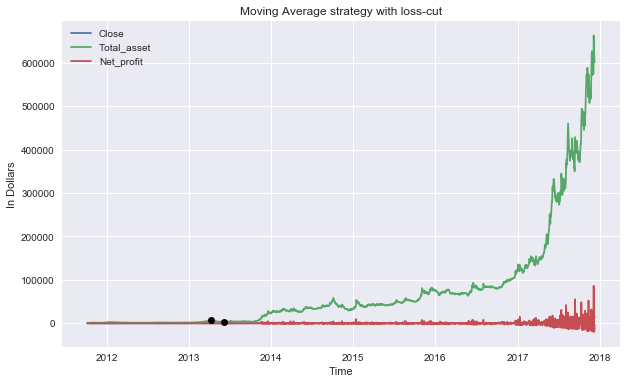

           Targeted portion = 0.9 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 599870.34
           The Quality of the Portfolio is 0.64
           Max Drawdown is -57.0 %


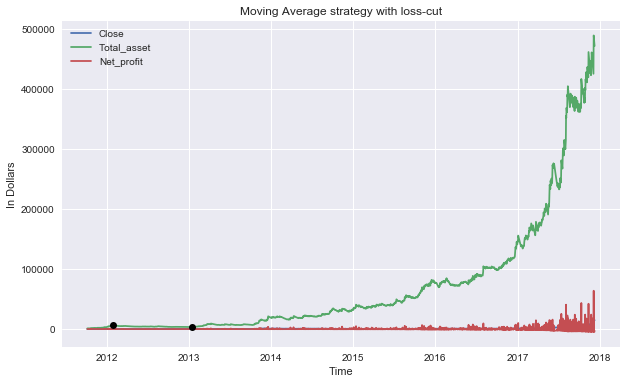

           Targeted portion = 0.9 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 470064.02
           The Quality of the Portfolio is 0.69
           Max Drawdown is -47.0 %


In [61]:
test_portion_list = np.arange(0.3, 0.9, 0.1)         
loss_cut_list = [0.80, 0.85, 0.90, 0.95, 0.97, 0.99]
result_list = []
for portion in test_portion_list:
    for loss_cut in loss_cut_list:
        stock_df = simulate_algo(ref_stock_df, init_cash=1000, target_port_ratio=portion, loss_cut_ratio=loss_cut)
        record_ = calc_max_drawdown(stock_df)
        draw_result_of_sim(stock_df, record_)
        result_list.append([round(get_final_total_value(stock_df),2), round(calc_quality_of_port(stock_df),2), record_[0]]) 
        print('           Targeted portion =', portion,",",'Loss cut =',loss_cut)
        print('           Initial Investment Value $ 1000.00')
        print('           Final Portfolio Value: $', result_list[-1][0])
        print('           The Quality of the Portfolio is', result_list[-1][1])
        print('           Max Drawdown is', record_[0], '%')

In [62]:
result_list

[[3748.5900000000001, 1.29, -51.0],
 [4726.25, 1.32, -48.0],
 [4277.21, 1.37, -49.0],
 [4109.5900000000001, 1.33, -44.0],
 [4523.5600000000004, 1.45, -35.0],
 [9617.2700000000004, 1.26, -24.0],
 [8001.0100000000002, 1.27, -59.0],
 [6865.5500000000002, 1.24, -63.0],
 [6032.3199999999997, 1.12, -59.0],
 [12056.059999999999, 1.36, -44.0],
 [10872.690000000001, 1.33, -46.0],
 [18398.049999999999, 1.1, -29.0],
 [9503.5599999999995, 1.16, -74.0],
 [10509.799999999999, 1.16, -67.0],
 [9058.1000000000004, 1.06, -66.0],
 [13349.790000000001, 1.34, -52.0],
 [29181.110000000001, 1.16, -48.0],
 [51361.169999999998, 0.93, -32.0],
 [12121.209999999999, 1.07, -76.0],
 [12125.940000000001, 0.98, -74.0],
 [15258.879999999999, 1.12, -70.0],
 [18933.139999999999, 1.25, -65.0],
 [50895.07, 0.99, -54.0],
 [99771.729999999996, 0.84, -32.0],
 [17176.650000000001, 1.01, -79.0],
 [13797.27, 0.85, -79.0],
 [33904.120000000003, 1.08, -71.0],
 [60739.459999999999, 1.07, -65.0],
 [132206.63, 0.84, -53.0],
 [214947